# Proyek Analisis Data: Air Quality
- **Nama:** Refa Muhammad
- **Email:** refamuhammadr@gmail.com
- **ID Dicoding:** MC222D5Y1282

# Pertanyaan Bisnis
- **pertanyaan 1:** Apakah arah angin (wd) memengaruhi konsentrasi polutan tertentu?
- **pertanyaan 2:** Apakah curah hujan (RAIN) memengaruhi konsentrasi polutan tertentu (misalnya, PM2.5 atau PM10)?

## Import Semua Packages/Library yang Digunakan

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import folium
from folium.plugins import HeatMap

## Data Wrangling

### Gathering Data

In [88]:
# Path folder data
data_folder = "data/"

# List semua file CSV di folder data
file_list = [f for f in os.listdir(data_folder) if f.endswith(".csv")]

# List untuk menyimpan DataFrame
df_list = []

# Looping untuk membaca dan menambahkan nama station
for file in file_list:
    file_path = os.path.join(data_folder, file)
    
    # Membaca dataset
    df = pd.read_csv(file_path)
    
    # Menambahkan kolom 'station' sesuai nama file (tanpa ekstensi .csv)
    df['station'] = df['station'].apply(lambda x: x.replace("PRSA_Data_", "").split("_")[0])
    
    # Menyimpan dataframe ke dalam list
    df_list.append(df)

# Menggabungkan semua dataset
df_combined = pd.concat(df_list, ignore_index=True)


In [89]:
# Menampilkan 5 data teratas
print(df_combined.head())

   year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  \
0  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0   
1  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2   
2  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5   
3  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5   
4  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2   

   DEWP  RAIN   wd  WSPM       station  No  
0 -18.8   0.0  NNW   4.4  Aotizhongxin NaN  
1 -18.2   0.0    N   4.7  Aotizhongxin NaN  
2 -18.2   0.0  NNW   5.6  Aotizhongxin NaN  
3 -19.4   0.0   NW   3.1  Aotizhongxin NaN  
4 -19.5   0.0    N   2.0  Aotizhongxin NaN  


**Insight:**
- Dataset berisi data kualitas udara dari beberapa stasiun di Beijing selama periode 2013 - 2017
- Data mencakup polutan utama (PM2.5, PM10, SO2, NO2, CO, O3) serta faktor cuaca seperti suhu, tekanan udara, curah hujan, dan kecepatan angin.
- Setiap file merepresentasikan satu stasiun pengukuran, sehingga penggabungan data memungkinkan analisis lintas lokasi untuk melihat pola polusi udara.
- Jumlah sampel di tiap file sekitar 35.064 data, sehingga setelah penggabungan, total data cukup besar untuk analisis tren jangka panjang.
- Terdapat beberapa kemungkinan nilai hilang (missing values) atau anomali, terutama pada data polutan dan cuaca, yang perlu ditangani dalam tahap pembersihan data.

### Assessing Data

In [90]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876602 entries, 0 to 876601
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     876602 non-null  int64  
 1   month    876602 non-null  int64  
 2   day      876602 non-null  int64  
 3   hour     876602 non-null  int64  
 4   PM2.5    867084 non-null  float64
 5   PM10     869497 non-null  float64
 6   SO2      866851 non-null  float64
 7   NO2      863252 non-null  float64
 8   CO       853889 non-null  float64
 9   O3       862111 non-null  float64
 10  TEMP     876151 non-null  float64
 11  PRES     876159 non-null  float64
 12  DEWP     876146 non-null  float64
 13  RAIN     876161 non-null  float64
 14  wd       874640 non-null  object 
 15  WSPM     876241 non-null  float64
 16  station  876602 non-null  object 
 17  No       455832 non-null  float64
dtypes: float64(12), int64(4), object(2)
memory usage: 120.4+ MB


In [91]:
df_combined.isna().sum()

year            0
month           0
day             0
hour            0
PM2.5        9518
PM10         7105
SO2          9751
NO2         13350
CO          22713
O3          14491
TEMP          451
PRES          443
DEWP          456
RAIN          441
wd           1962
WSPM          361
station         0
No         420770
dtype: int64

In [92]:
print("Jumlah duplikasi: ", df_combined.duplicated().sum())

Jumlah duplikasi:  35064


In [93]:
df_combined.describe()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,No
count,876602.000000,876602.000000,876602.000000,876602.000000,867084.000000,869497.000000,866851.000000,863252.000000,853889.000000,862111.000000,876151.000000,876159.000000,876146.000000,876161.000000,876241.000000,455832.000000
mean,2014.662556,6.522921,15.729604,11.499975,79.269723,103.923167,15.709085,49.716352,930.902210,57.728802,13.541321,1010.630700,2.447364,0.064289,1.734824,17532.500000
std,1.177199,3.448705,8.800115,6.922203,80.606760,91.718590,21.577039,35.133187,877.254255,56.661570,11.434186,10.480723,13.798162,0.818214,1.249355,10122.116018
min,2013.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000,1.000000
25%,2014.000000,4.000000,8.000000,5.000000,20.000000,35.000000,2.284800,22.000000,500.000000,11.000000,3.100000,1002.100000,-9.000000,0.000000,0.900000,8766.750000
50%,2015.000000,7.000000,16.000000,11.000000,54.000000,81.000000,7.000000,42.000000,750.000000,45.196200,14.500000,1010.250000,3.000000,0.000000,1.400000,17532.500000
75%,2016.000000,10.000000,23.000000,17.000000,110.000000,144.000000,19.000000,70.000000,900.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,2.200000,26298.250000
max,2017.000000,12.000000,31.000000,23.000000,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000,35064.000000


**Insight:**
- Dataset memiliki 455.832 baris dan 18 kolom, menunjukkan jumlah sampel yang cukup besar untuk analisis kualitas udara.
- Terdapat missing values pada beberapa kolom penting, seperti PM2.5, PM10, SO2, NO2, CO, dan O3, yang dapat memengaruhi hasil analisis jika tidak ditangani dengan baik.
- Ada kemungkinan nilai outlier, terutama pada PM2.5, PM10, CO, dan O3, yang memiliki nilai maksimum sangat tinggi (contoh: PM2.5 & PM10 mencapai 999). Ini bisa menjadi indikasi kesalahan pengukuran atau data default error.
- Kolom wd (arah angin) berisi data kategori, perlu dicek apakah ada kategori yang tidak valid atau tidak lengkap.
- Curah hujan (RAIN) sebagian besar bernilai nol, yang bisa menunjukkan banyaknya hari tanpa hujan atau adanya kesalahan pencatatan.
- Distribusi suhu (TEMP) tampak wajar, dengan nilai berkisar dari -19.9°C hingga 41.6°C, namun nilai minimum (-19.9°C) cukup ekstrem dan perlu diperiksa apakah masuk akal berdasarkan lokasi pengukuran.
- Data tekanan udara (PRES) memiliki rentang antara 982.4 hingga 1042.8 hPa, yang masih dalam batas normal untuk tekanan atmosfer.
- Kecepatan angin (WSPM) memiliki nilai minimum 0, yang perlu diperiksa apakah memang ada periode tanpa angin atau ini merupakan kesalahan pencatatan.

### Cleaning Data

In [94]:
# 1. Menghapus kolom yang tidak diperlukan
df_combined.drop(columns=['No'], inplace=True)
# Menampilkan 5 data teratas
print(df_combined.head())

   year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  \
0  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0   
1  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2   
2  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5   
3  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5   
4  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2   

   DEWP  RAIN   wd  WSPM       station  
0 -18.8   0.0  NNW   4.4  Aotizhongxin  
1 -18.2   0.0    N   4.7  Aotizhongxin  
2 -18.2   0.0  NNW   5.6  Aotizhongxin  
3 -19.4   0.0   NW   3.1  Aotizhongxin  
4 -19.5   0.0    N   2.0  Aotizhongxin  


In [95]:
# 2. Menangani missing values
# Interpolasi untuk data numerik
df_combined.interpolate(method='linear', inplace=True)

C:\Users\refam\AppData\Local\Temp\ipykernel_14308\2165354991.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_combined.interpolate(method='linear', inplace=True)


In [96]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876602 entries, 0 to 876601
Data columns (total 17 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     876602 non-null  int64  
 1   month    876602 non-null  int64  
 2   day      876602 non-null  int64  
 3   hour     876602 non-null  int64  
 4   PM2.5    876602 non-null  float64
 5   PM10     876602 non-null  float64
 6   SO2      876602 non-null  float64
 7   NO2      876602 non-null  float64
 8   CO       876602 non-null  float64
 9   O3       876602 non-null  float64
 10  TEMP     876602 non-null  float64
 11  PRES     876602 non-null  float64
 12  DEWP     876602 non-null  float64
 13  RAIN     876602 non-null  float64
 14  wd       874640 non-null  object 
 15  WSPM     876602 non-null  float64
 16  station  876602 non-null  object 
dtypes: float64(11), int64(4), object(2)
memory usage: 113.7+ MB


In [97]:
df_combined.isna().sum()

year          0
month         0
day           0
hour          0
PM2.5         0
PM10          0
SO2           0
NO2           0
CO            0
O3            0
TEMP          0
PRES          0
DEWP          0
RAIN          0
wd         1962
WSPM          0
station       0
dtype: int64

In [98]:
# Isi missing value
df_combined.interpolate(method='linear', inplace=True)

# Isi missing value di kolom 'wd' dengan modus (nilai paling sering)
df_combined['wd'].fillna(df_combined['wd'].mode()[0], inplace=True)

# Hanya isi missing value dengan median untuk kolom numerik
df_combined.fillna(df_combined.select_dtypes(include=['number']).median(), inplace=True)


C:\Users\refam\AppData\Local\Temp\ipykernel_14308\1542175807.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_combined.interpolate(method='linear', inplace=True)
C:\Users\refam\AppData\Local\Temp\ipykernel_14308\1542175807.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined['wd'].fillna(df_combined['wd'].mode()[0], inplace=True)


In [99]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876602 entries, 0 to 876601
Data columns (total 17 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     876602 non-null  int64  
 1   month    876602 non-null  int64  
 2   day      876602 non-null  int64  
 3   hour     876602 non-null  int64  
 4   PM2.5    876602 non-null  float64
 5   PM10     876602 non-null  float64
 6   SO2      876602 non-null  float64
 7   NO2      876602 non-null  float64
 8   CO       876602 non-null  float64
 9   O3       876602 non-null  float64
 10  TEMP     876602 non-null  float64
 11  PRES     876602 non-null  float64
 12  DEWP     876602 non-null  float64
 13  RAIN     876602 non-null  float64
 14  wd       876602 non-null  object 
 15  WSPM     876602 non-null  float64
 16  station  876602 non-null  object 
dtypes: float64(11), int64(4), object(2)
memory usage: 113.7+ MB


In [100]:
# 3. Menangani outliers
# Menghapus nilai ekstrem (999 pada PM2.5 dan PM10 dianggap outlier)
outlier_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
for col in outlier_cols:
    df_combined[col] = df_combined[col].apply(lambda x: None if x >= 999 else x)
    df_combined[col].interpolate(method='linear', inplace=True)


C:\Users\refam\AppData\Local\Temp\ipykernel_14308\4253942491.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined[col].interpolate(method='linear', inplace=True)


In [101]:
df_combined.drop_duplicates(inplace=True)

In [102]:
# **4. Cek hasil setelah cleaning**
print(df_combined.info())
print(df_combined.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 429533 entries, 0 to 876520
Data columns (total 17 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     429533 non-null  int64  
 1   month    429533 non-null  int64  
 2   day      429533 non-null  int64  
 3   hour     429533 non-null  int64  
 4   PM2.5    429533 non-null  float64
 5   PM10     429533 non-null  float64
 6   SO2      429533 non-null  float64
 7   NO2      429533 non-null  float64
 8   CO       429533 non-null  float64
 9   O3       429533 non-null  float64
 10  TEMP     429533 non-null  float64
 11  PRES     429533 non-null  float64
 12  DEWP     429533 non-null  float64
 13  RAIN     429533 non-null  float64
 14  wd       429533 non-null  object 
 15  WSPM     429533 non-null  float64
 16  station  429533 non-null  object 
dtypes: float64(11), int64(4), object(2)
memory usage: 59.0+ MB
None
                year          month            day           hour  \
count  429533.0

In [103]:
df_combined.to_csv("data/cleaned_air_quality_data.csv", index=False)

**Insight:**
- Tidak ada missing values (Non-Null Count di setiap kolom sama dengan total entri 429,533).
- Tipe data sudah sesuai (angka dalam int64/float64, kategori dalam object).
- Distribusi data masuk akal (tidak ada nilai ekstrem yang aneh, meskipun ada outlier seperti PM2.5 hingga 957).

## Exploratory Data Analysis (EDA)

### Explore Data cleaned_air_quality

In [104]:
df_combined.describe(include="all")

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
count,429533.000000,429533.000000,429533.000000,429533.000000,429533.000000,429533.000000,429533.000000,429533.000000,429533.000000,429533.000000,429533.000000,429533.000000,429533.000000,429533.000000,429533,429533.000000,429533
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,12
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NE,NaN,Dongsi
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46266,NaN,36537
mean,2014.655326,6.526400,15.744674,11.496325,80.385900,105.472021,16.051692,50.771187,649.078126,57.238767,13.528789,1010.740239,2.510825,0.064536,NaN,1.726432,NaN
std,1.180353,3.449795,8.799850,6.923193,81.299649,92.719466,22.046656,35.203875,229.231687,56.989953,11.445879,10.480110,13.790260,0.825027,NaN,1.244782,NaN
min,2013.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,NaN,0.000000,NaN
25%,2014.000000,4.000000,8.000000,5.000000,21.000000,36.000000,3.000000,23.000000,500.000000,10.000000,3.100000,1002.200000,-8.900000,0.000000,NaN,0.900000,NaN
50%,2015.000000,7.000000,16.000000,11.000000,56.000000,83.000000,7.000000,43.000000,700.000000,44.000000,14.500000,1010.400000,3.100000,0.000000,NaN,1.400000,NaN
75%,2016.000000,10.000000,23.000000,17.000000,112.000000,146.000000,20.000000,71.000000,850.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,NaN,2.200000,NaN


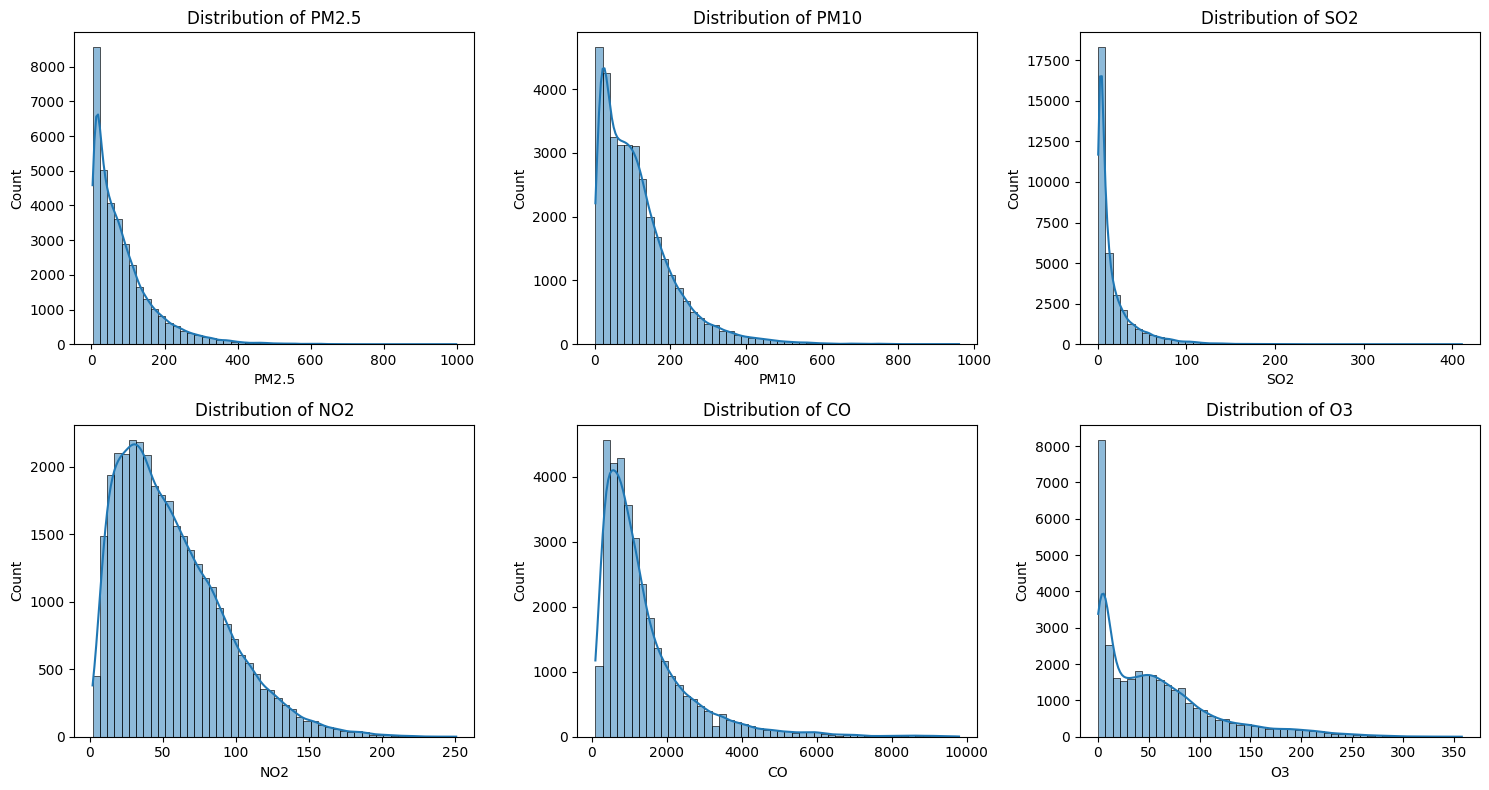

In [105]:
num_cols = ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3"]
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

**Insight:**
- Semua distribusi tampak skewed ke kanan (positively skewed)
- Distribusinya sangat mirip, menunjukkan bahwa konsentrasi PM2.5 dan PM10 sering berkorelasi dalam kejadian polusi udara.
- Ada lonjakan tinggi di nilai rendah, yang menunjukkan banyak pengukuran dengan konsentrasi kecil.
- SO2 dan O3 memiliki puncak yang lebih curam, artinya sebagian besar nilai sangat kecil.
- NO2 dan CO lebih menyebar, menunjukkan variasi yang lebih besar dalam konsentrasi mereka.

## Visualization & Explanatory Analysis

### Pertanyaan 1:
**Apakah arah angin (wd) memengaruhi konsentrasi polutan tertentu?**

C:\Users\refam\AppData\Local\Temp\ipykernel_14308\2412976281.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='wd', y=col, data=mean_polutan_by_wd, palette='viridis')
C:\Users\refam\AppData\Local\Temp\ipykernel_14308\2412976281.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='wd', y=col, data=mean_polutan_by_wd, palette='viridis')
C:\Users\refam\AppData\Local\Temp\ipykernel_14308\2412976281.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='wd', y=col, data=mean_polutan_by_wd, palette='viridis')
C:\Users\refam\AppData\Local

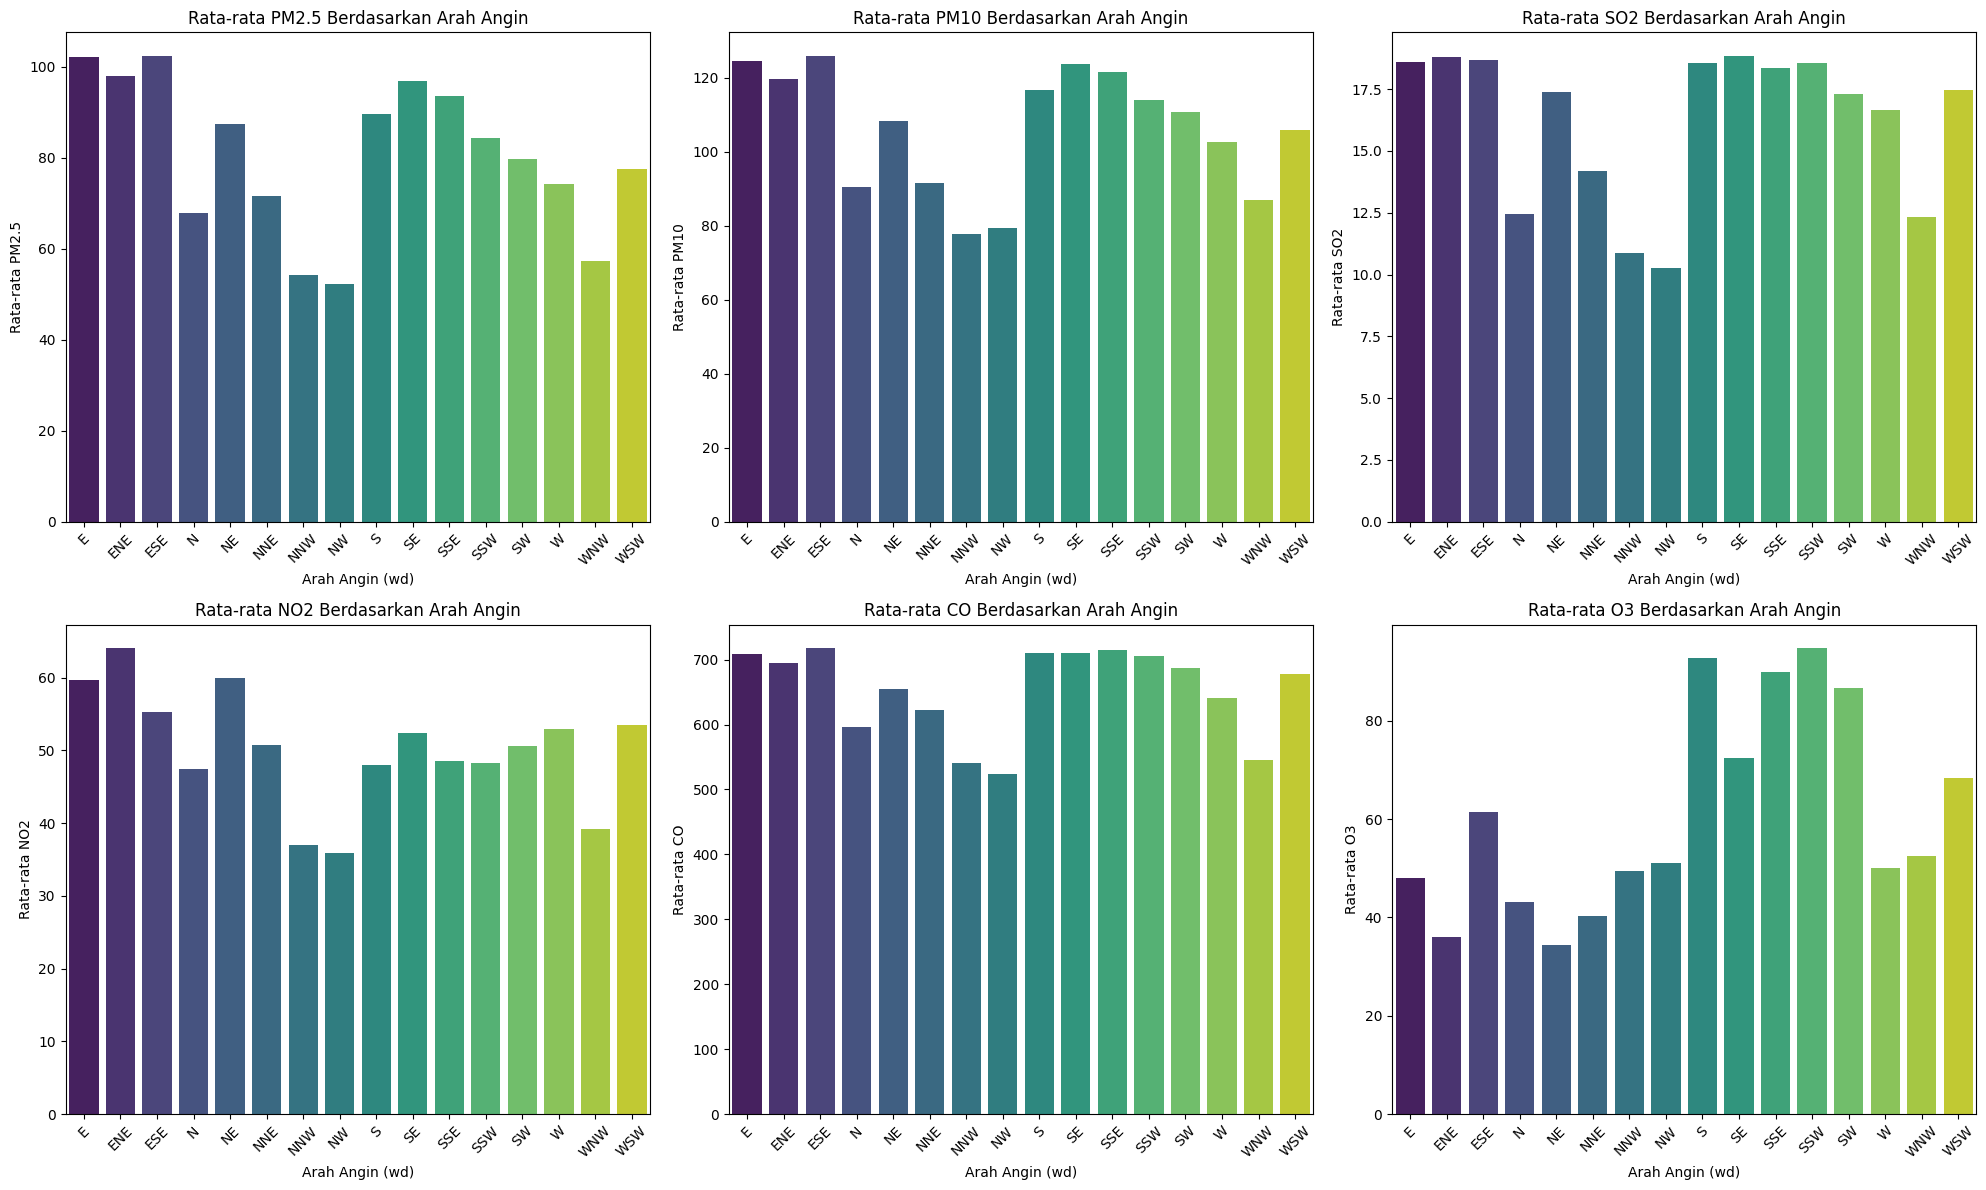

In [106]:
# Kolom polutan yang akan dianalisis
num_cols = ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3"]

# Buat figure dan subplot
plt.figure(figsize=(20, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)  # 2 baris, 3 kolom untuk 6 polutan
    # Hitung rata-rata konsentrasi polutan untuk setiap arah angin
    mean_polutan_by_wd = df_combined.groupby('wd')[col].mean().reset_index()
    # Buat bar plot
    sns.barplot(x='wd', y=col, data=mean_polutan_by_wd, palette='viridis')
    plt.title(f'Rata-rata {col} Berdasarkan Arah Angin')
    plt.xlabel('Arah Angin (wd)')
    plt.ylabel(f'Rata-rata {col}')
    plt.xticks(rotation=45)  # Rotasi label arah angin agar lebih mudah dibaca

plt.tight_layout()
plt.show()

**Insight:**
- **PM2.5:** Konsentrasi tertinggi terlihat pada arah angin E, ENE, dan ESE (timur dan sekitarnya), dengan nilai sekitar 100 μg/m³. Konsentrasi terendah berada pada arah angin NNW dan W, dengan nilai sekitar 50 μg/m³.
- **PM10:** Pola serupa dengan PM2.5, dengan konsentrasi tertinggi dari arah E, ENE, dan ESE. Arah angin dari timur menghasilkan konsentrasi PM10 >120 μg/m³, sedangkan dari NNW dan W lebih rendah (~80 μg/m³).
- **SO2:** Konsentrasi tertinggi berasal dari arah E, ENE, ESE, dan juga S, SSE, dan SW dengan nilai mendekati 18 μg/m³. Konsentrasi terendah dari arah NNW dan W sekitar 10 μg/m³.
- **NO2:** Konsentrasi tertinggi dari ENE (~65 μg/m³), sedangkan konsentrasi terendah dari arah NW dan NNW (~35 μg/m³).
- **CO:** Konsentrasi tertinggi dari arah E, ENE, ESE dan S, SE, SSE, SSW dengan nilai sekitar 700 μg/m³. Konsentrasi terendah dari arah NW dan NNW sekitar 500 μg/m³.
- **O3:** Menunjukkan pola berbeda, dengan konsentrasi tertinggi dari arah S, SE, SSE, SSW (~90 μg/m³), sedangkan konsentrasi terendah dari arah E, ENE, N, NNE, NNW (~35 μg/m³).

### Pertanyaan 2:

### Pertanyaan 2:
**Apakah curah hujan (RAIN) memengaruhi konsentrasi polutan tertentu (misalnya, PM2.5 atau PM10)?**

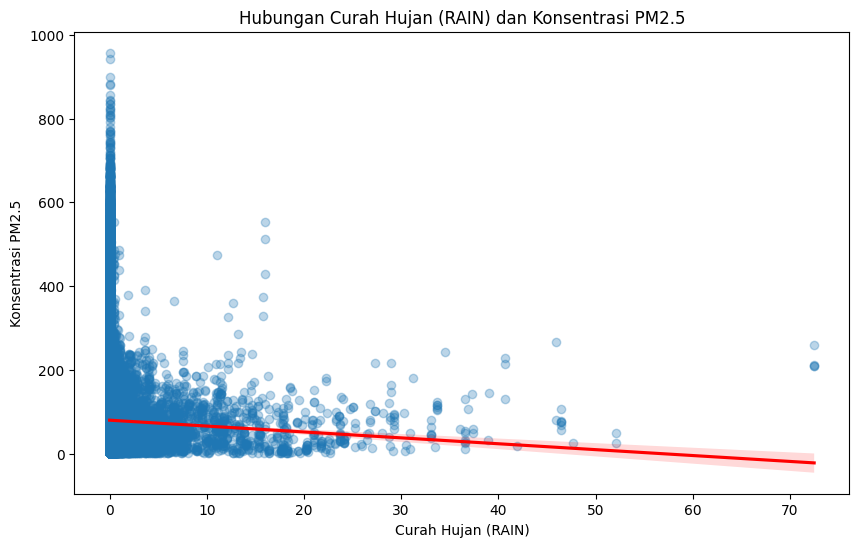

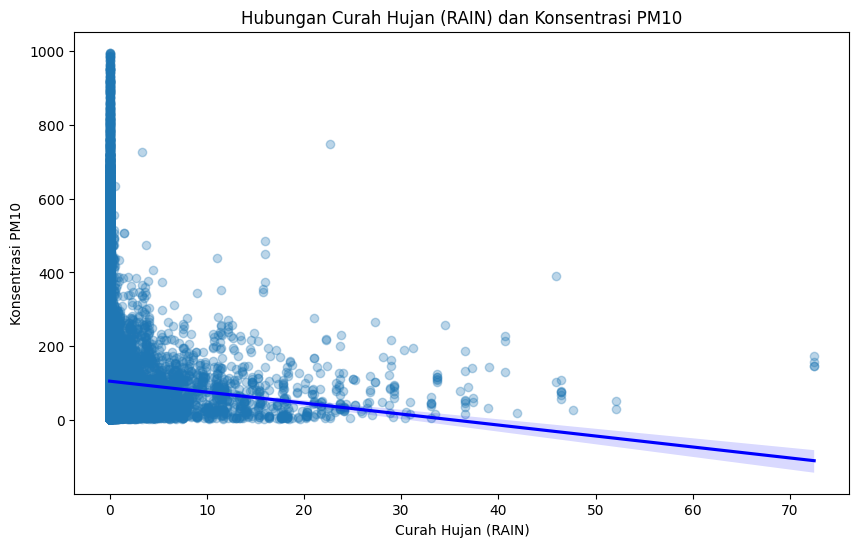

In [107]:
# Analisis untuk PM2.5
plt.figure(figsize=(10, 6))
sns.regplot(x='RAIN', y='PM2.5', data=df_combined, scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title('Hubungan Curah Hujan (RAIN) dan Konsentrasi PM2.5')
plt.xlabel('Curah Hujan (RAIN)')
plt.ylabel('Konsentrasi PM2.5')
plt.show()

# Analisis untuk PM10
plt.figure(figsize=(10, 6))
sns.regplot(x='RAIN', y='PM10', data=df_combined, scatter_kws={'alpha': 0.3}, line_kws={'color': 'blue'})
plt.title('Hubungan Curah Hujan (RAIN) dan Konsentrasi PM10')
plt.xlabel('Curah Hujan (RAIN)')
plt.ylabel('Konsentrasi PM10')
plt.show()

**Insight:**
- Hubungan Curah Hujan dengan Konsentrasi PM10, Terlihat adanya hubungan negatif (tren menurun) antara curah hujan dan konsentrasi PM10, ditunjukkan oleh garis biru yang menurun.
- Konsentrasi PM10 tertinggi (mencapai 1000 μg/m³) terjadi saat curah hujan mendekati 0.
- Pada curah hujan di atas 30 mm, konsentrasi PM10 jarang melebihi 200 μg/m³.
- Pola serupa juga terlihat pada hubungan curah hujan dengan PM2.5, ditandai dengan garis merah yang menurun.
- Konsentrasi PM2.5 tertinggi (sekitar 900-950 μg/m³) terjadi saat curah hujan minimal.
- Pada curah hujan tinggi (>40 mm), konsentrasi PM2.5 umumnya berada di bawah 100 μg/m³.

## Analisis Lanjutan

### Geospatial Analysis Air Quality

In [ ]:
# Contoh koordinat stasiun
station_locations = {
    "Dingling": [40.290, 116.220],
    "Aotizhongxin": [40.000, 116.407],
    "Changping": [40.220, 116.234],
    "Guanyuan": [39.930, 116.362],
    "Huairou": [40.320, 116.630],
    "Nongzhanguan": [39.933, 116.467],
    "Shunyi": [40.130, 116.653],
    "Tiantan": [39.881, 116.414],
    "Wanshouxigong": [39.888, 116.349],
    "Dongsi": [39.928, 116.417]
}

# Load dataset 
df = df_combined.copy()

# Filter data terbaru (misalnya tahun 2017) dan hitung rata-rata hanya untuk kolom numerik
df_latest = df[df['year'] == df['year'].max()].groupby('station').mean(numeric_only=True).reset_index()

# Menambahkan koordinat ke dalam dataframe
df_latest['latitude'] = df_latest['station'].map(lambda x: station_locations.get(x, [None, None])[0])
df_latest['longitude'] = df_latest['station'].map(lambda x: station_locations.get(x, [None, None])[1])

# Menghapus nilai NaN
map_data = df_latest.dropna(subset=['latitude', 'longitude', 'PM2.5'])

# Membuat peta dengan Folium
m = folium.Map(location=[39.9, 116.4], zoom_start=10)

# Menambahkan titik lokasi stasiun dengan warna berdasarkan PM2.5
for _, row in map_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=8,
        color='red' if row['PM2.5'] > 100 else 'orange' if row['PM2.5'] > 50 else 'green',
        fill=True,
        fill_color='red' if row['PM2.5'] > 100 else 'orange' if row['PM2.5'] > 50 else 'green',
        fill_opacity=0.7,
        popup=folium.Popup(f"{row['station']}: {row['PM2.5']} µg/m³", parse_html=True)
    ).add_to(m)

# Menambahkan heatmap
heat_data = [[row['latitude'], row['longitude'], row['PM2.5']] for _, row in map_data.iterrows()]
HeatMap(heat_data).add_to(m)

# Simpan peta ke file HTML
m.save("air_quality_map.html")

# Menampilkan peta
m

## Conclusion

- **Conclution pertanyaan 1:** Arah angin memang mempengaruhi konsentrasi polutan secara signifikan. Polutan PM2.5, PM10, SO2, NO2, dan CO umumnya memiliki konsentrasi tertinggi ketika angin bertiup dari arah timur (E, ENE, ESE), sementara O3 memiliki pola berbeda dengan konsentrasi tertinggi dari arah selatan. Ini menunjukkan kemungkinan adanya sumber polusi yang berbeda berdasarkan arah angin, seperti kawasan industri, jalan raya padat, atau faktor geografis lainnya yang mempengaruhi penyebaran polutan.
- **Conclution pertanyaan 2:** Curah hujan memiliki efek signifikan dalam menurunkan konsentrasi polutan PM10 dan PM2.5 di udara. Hujan berperan sebagai mekanisme alami untuk membersihkan udara dari partikel-partikel halus. Pola ini konsisten dengan teori dan penelitian yang menunjukkan bahwa hujan dapat menjadi faktor penting dalam meningkatkan kualitas udara melalui proses deposisi basah (wet deposition).